In [2]:
# !pip install adjustText

from matplotlib        import collections             as matcoll
# from matplotlib.colors import LinearSegmentedColormap
# from matplotlib.colors import TwoSlopeNorm
# from matplotlib.pyplot import rc_context
from scipy.cluster     import hierarchy
# from adjustText        import adjust_text

import matplotlib.pyplot as plt
# import matplotlib
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
# import math
# import glob
# import h5py
import sys
import os

main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
import warnings
warnings.filterwarnings("ignore")

sys.path.append(main_path)
# from models.clustering.logistic_regression_leiden_clusters import *
from models.evaluation.folds import load_existing_split
from models.clustering.correlations import *
from models.clustering.data_processing import *
# from models.clustering.leiden_representations import include_tile_connections_frame
# from data_manipulation.utils import store_data
from IPython.display import clear_output
clear_output()


### Setting variables

In [37]:
# Resolution and fold for the tile clustering and slide representations.
resolution     = 2.0
fold_number    = 4
groupby        = 'leiden_%s' % resolution

# Folder run.
dataset     = 'Meso'
additional_dataset = 'TCGA_MESO'
meta_folder     = '750K'
matching_field  = 'slides'


# Pickle files.
folds_pickle = '{}/files/pkl_{}_he_test_train_slides.pkl'.format(main_path, dataset)

# Tile representation files.
h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset, dataset)
h5_additional_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, additional_dataset, additional_dataset)
figure_path = main_path + '/workflow/figures/HPC_figures/'
os.makedirs(figure_path, exist_ok=True)
main_cluster_path = h5_complete_path.split('hdf5_')[0]
main_cluster_path = os.path.join(main_cluster_path, meta_folder)
adatas_path       = os.path.join(main_cluster_path, 'adatas')

2611 HPC: 24
267 HPC: 45


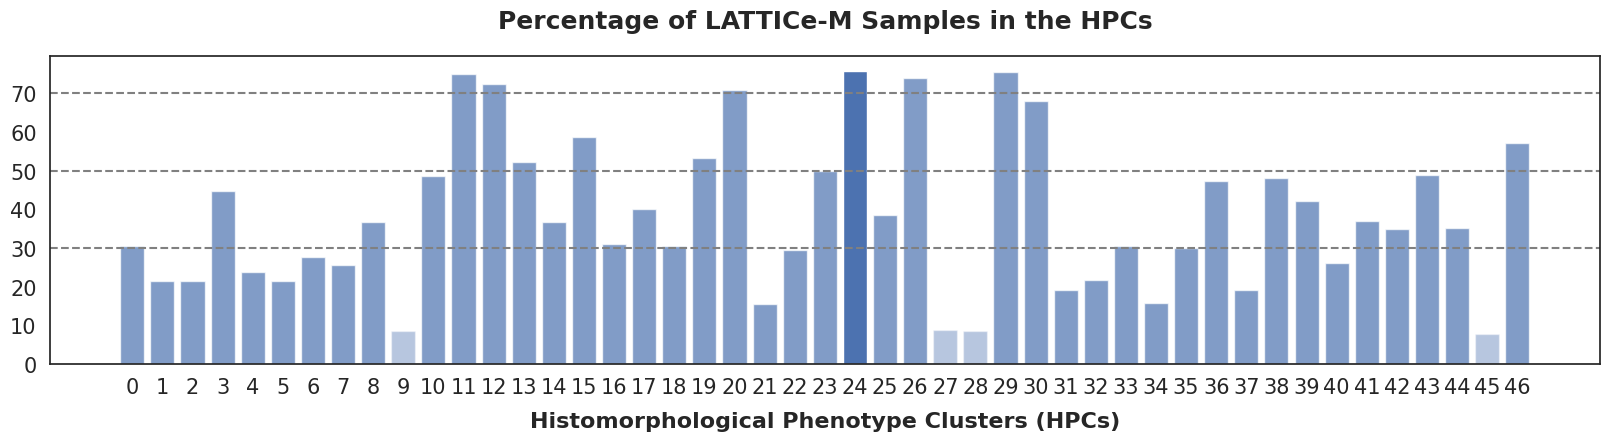

In [39]:
from skbio.stats.composition import clr_inv

subtype_csvs_path = '{}/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/{}/subtype_csvs'.format(main_path, meta_folder)
df_all = pd.read_csv('{}/{}_{}_leiden_{}_fold{}.csv'.format(subtype_csvs_path, 'Meso', 'clr', '2p0', 4), index_col=0)
df_all.drop('Meso_type_x', axis=1, inplace=True)
leiden_clusters = [col for col in df_all.columns if col.isnumeric()]
inversed_df = pd.DataFrame(clr_inv(df_all[leiden_clusters]), columns=leiden_clusters)




sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(20,4))
hpc_df = inversed_df.copy()*100
hpc_df = hpc_df > 1
hpc_df_percentages = hpc_df.astype(int).sum(axis=0)/hpc_df.shape[0]*100




ax.bar(hpc_df_percentages.index, hpc_df_percentages.values, alpha=0.7, align='center')
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
ax.axhline(70, color='gray', linestyle='--')
ax.axhline(50, color='gray', linestyle='--')
ax.axhline(30, color='gray', linestyle='--')
# ax.axhline(15, color='gray', linestyle='--')

ax.set_xlabel('Histomorphological Phenotype Clusters (HPCs)', fontsize=16, fontweight='bold', labelpad=10)
ax.set_title('Percentage of LATTICe-M Samples in the HPCs', fontsize=18, fontweight='bold', pad=20, loc='center')
for i, (v, bar) in enumerate(zip(hpc_df_percentages.values, ax.patches)):
    if v == hpc_df_percentages.max():
        bar.set_alpha(1)
    if v<15:
        bar.set_alpha(0.4)
print(hpc_df.sum().max(), 'HPC:', hpc_df.sum().idxmax())
print(hpc_df.sum().min(), 'HPC:', hpc_df.sum().idxmin())

435 HPC: 11
55 HPC: 9


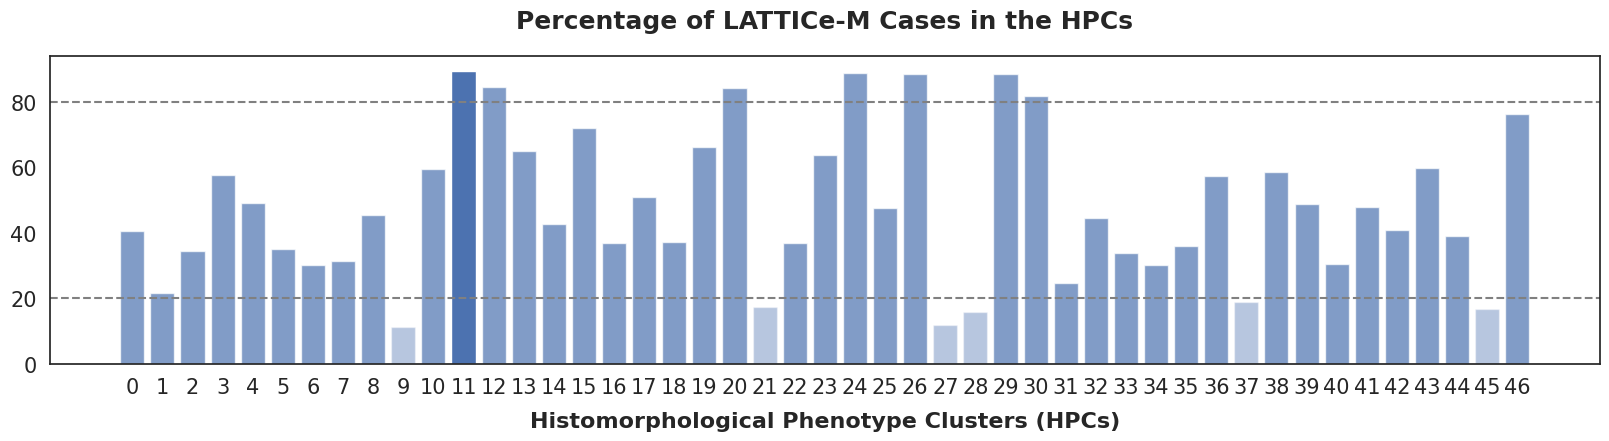

In [42]:
df_train = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_train_metadata.csv'.format(main_path, 'Meso', meta_folder , '2p0', 4), index_col=0)
df_test = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_test_metadata.csv'.format(main_path, 'Meso', meta_folder , '2p0', 4), index_col=0)
df_all = pd.concat([df_train, df_test])
leiden_clusters = [col for col in df_all.columns if col.isnumeric()]
inversed_df = pd.DataFrame(clr_inv(df_all[leiden_clusters]), columns=leiden_clusters)


sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(20,4))
hpc_df = inversed_df.copy()*100
hpc_df = hpc_df > 1
hpc_df_percentages = hpc_df.astype(int).sum(axis=0)/hpc_df.shape[0]*100


ax.bar(hpc_df_percentages.index, hpc_df_percentages.values, alpha=0.7, align='center')
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
ax.axhline(80, color='gray', linestyle='--')
# ax.axhline(50, color='gray', linestyle='--')
ax.axhline(20, color='gray', linestyle='--')
ax.set_xlabel('Histomorphological Phenotype Clusters (HPCs)', fontsize=16, fontweight='bold', labelpad=10)
ax.set_title('Percentage of LATTICe-M Cases in the HPCs', fontsize=18, fontweight='bold', pad=20, loc='center')
for i, (v, bar) in enumerate(zip(hpc_df_percentages.values, ax.patches)):
    if v == hpc_df_percentages.max():
        bar.set_alpha(1)
    if v<20:
        bar.set_alpha(0.4)

print(hpc_df.sum().max(), 'HPC:', hpc_df.sum().idxmax())
print(hpc_df.sum().min(), 'HPC:', hpc_df.sum().idxmin())


Info      count(%)
0                   Stage              
0                      N0  136 (26.56%)
1                      N1  211 (41.21%)
2                      N2      1 (0.2%)
3                      Nx  164 (32.03%)
0                 T_Stage              
0                     T1a     6 (1.17%)
1                     T1b    19 (3.71%)
2                      T2   94 (18.36%)
3                      T3  180 (35.16%)
4                      T4   97 (18.95%)
5                      Tx  116 (22.66%)
0               TNM_Stage              
0                      IA    13 (2.54%)
1                      IB   95 (18.55%)
2                      II    40 (7.81%)
3                    IIIA  112 (21.88%)
4                    IIIB   84 (16.41%)
5                      IV     3 (0.59%)
6                 Missing  165 (32.23%)
0         smoking_history              
0                 Current     22 (4.3%)
1               Ex-smoker  167 (32.62%)
2            Never smoked  100 (19.53%)
3                 Unknown  223 (43.55%)
0               wcc_score              
0                    High   66 (12.89%)
1                     Low     2 (0.39%)
2                  Normal  435 (84.96%)
3                 Unknown     9 (1.76%)
0  desmoplastic_component              
0                      No  124 (24.22%)
1                 Unknown  372 (72.66%)
2                     Yes    16 (3.12%)
0     confident_diagnosis              
0                      No     5 (0.98%)
1                     Yes  507 (99.02%)
0                HB_score              
0                       -     9 (1.76%)
1                    High      1 (0.2%)
2                     Low   213 (41.6%)
3                  Normal  289 (56.45%)

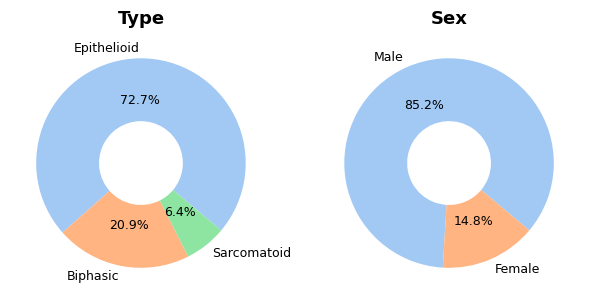

In [40]:
lattic_clinical = pd.read_csv(f'{main_path}/files/Meso_patients.csv')
col_list = ['Stage', 'T_Stage', 'TNM_Stage','smoking_history', 'wcc_score', 'desmoplastic_component', 'confident_diagnosis', 'HB_score']
df = pd.DataFrame()
for col in col_list:
    row = pd.DataFrame(lattic_clinical[col].value_counts().apply(lambda x: str(str(x)+' ('+ str(round(x/len(lattic_clinical)*100, 2)))+'%)').sort_index()).reset_index()
    header_row = pd.DataFrame([[col, '']], columns=['Info', 'count(%)'])
    row = row.rename(columns={col: 'Info', 'count': 'count(%)'})
    row = pd.concat([header_row, row], axis=0)
    df = pd.concat([df, row], axis=0)

df.to_csv(f'{figure_path}/dataset_info.csv', index=False)
display(df)


col_list = ['type', 'Sex']
fig, ax = plt.subplots(1,2, figsize=(6,4))
ax = ax.flatten()
bbox_props = dict(boxstyle="Round,pad=0.6", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, col in enumerate(col_list):
    ax[i].pie(lattic_clinical[col].value_counts(), autopct='%1.1f%%', wedgeprops=dict(width=0.6), startangle=-40, colors=sns.color_palette("pastel"), labels = lattic_clinical[col].value_counts().index.to_list(), textprops=dict(fontsize=9))
    ax[i].set_title(str.capitalize(col), fontsize=13, fontweight='bold')
    label_list = lattic_clinical[col].value_counts().index.to_list()
    # for j, p in enumerate(wedges):
    #     ang = (p.theta2 - p.theta1)/2. + p.theta1
    #     y = np.sin(np.deg2rad(ang))
    #     x = np.cos(np.deg2rad(ang))
    #     horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    #     connectionstyle = f"angle,angleA=0,angleB={ang}"
    #     kw["arrowprops"].update({"connectionstyle": connectionstyle})
    #     ax[i].annotate(label_list[j], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
    #                 horizontalalignment=horizontalalignment, **kw, fontsize=30, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{figure_path}/pie_chart_dataset.png')


### UMAP for HPCs

In [4]:
# PAGA.
adata_train, h5ad_path = read_h5ad_reference(h5_complete_path, meta_folder, groupby, fold_number)

if os.path.isfile(h5ad_path.replace('.h5ad', '_paga.h5ad')):
    adata_train = anndata.read_h5ad(h5ad_path.replace('.h5ad', '_paga.h5ad'))
else:
    sc.tl.paga(adata_train, groups=groupby, neighbors_key='nn_leiden')
    # sc.pl.paga(adata_train, layout='rt_circular', random_state=0, threshold=0.29, single_component=True, node_size_scale=15, node_size_power=1,
            # edge_width_scale=0.2, fontsize=10, fontoutline=5, frameon=False, show=True)
    # rsc.tl.umap(adata_train, neighbors_key='nn_leiden')
    sc.tl.umap(adata_train, init_pos="paga", neighbors_key='nn_leiden')
    sc.tl.tsne(adata_train, use_rep='X', perplexity=50, learning_rate=1000, random_state=42)
    adata_train.write(h5ad_path.replace('.h5ad', '_paga.h5ad'))

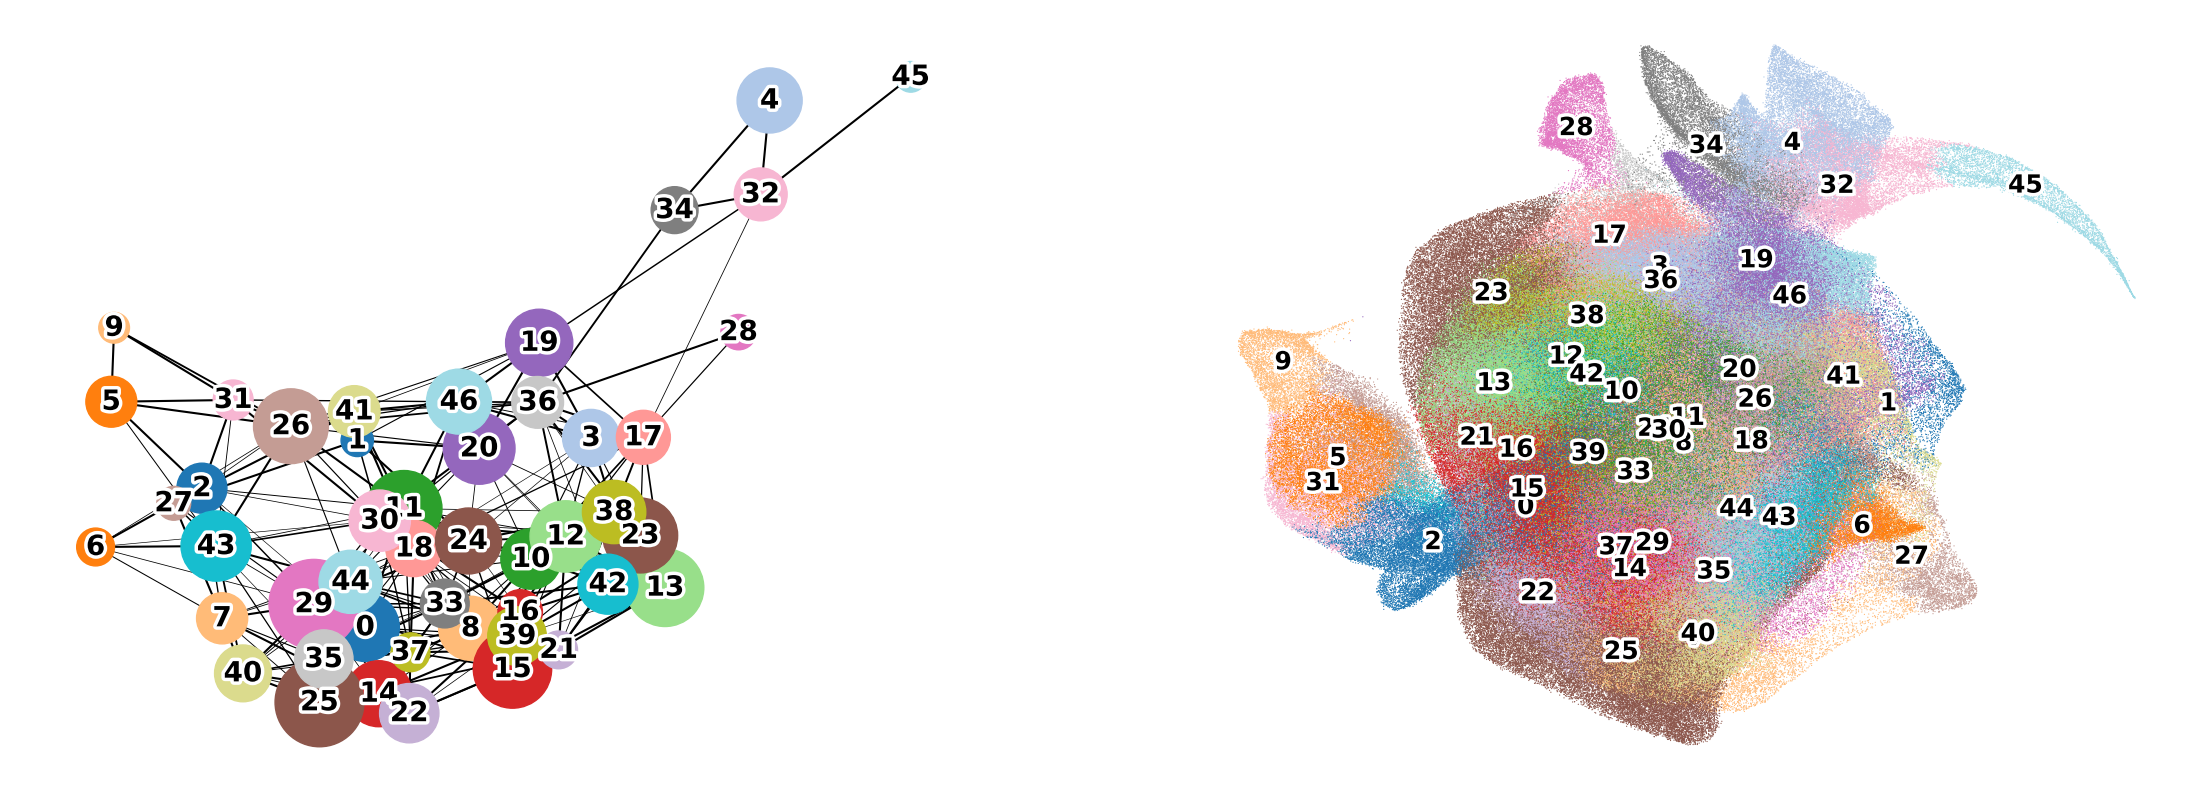

In [6]:
# Graph sahpe.
import matplotlib
fig = plt.figure(figsize=(28,10))
ax  = fig.add_subplot(1, 2, 1)
sc.pl.paga(adata_train, random_state=0, threshold=0.29,single_component=True, node_size_scale=15, node_size_power=1,
            edge_width_scale=0.2, fontsize=20, fontoutline=5, frameon=False, show=False, ax=ax, save=False)
ax.invert_yaxis()

ax1 = fig.add_subplot(1, 2, 2)
sc.pl.umap(adata_train, color=groupby, show=False, ax=ax1, legend_loc='on data', frameon=False, palette='tab20', legend_fontsize=18, size=3, legend_fontoutline = 5)
ax1.set_title('')
# plt.show()
plt.savefig(figure_path + '/PAGA_graph_umap.png', dpi=500)


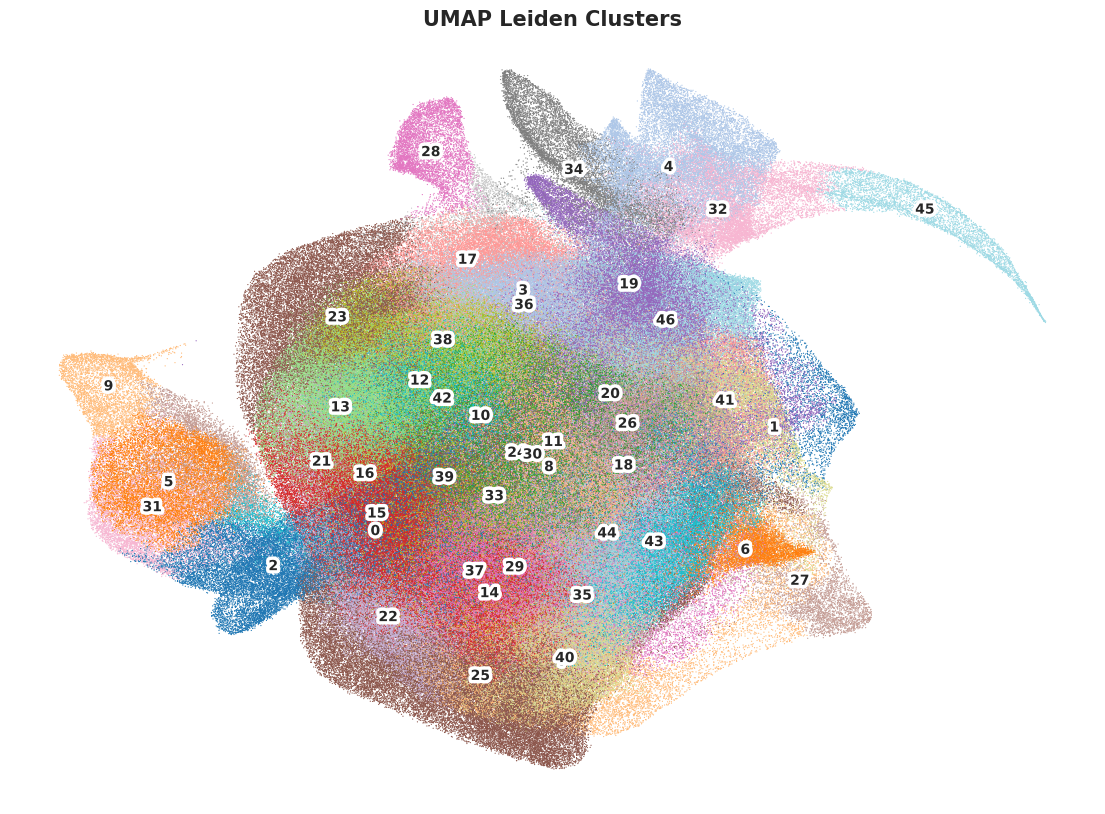

In [7]:
fig = plt.figure(figsize=(14,10))
sns.set_theme(style='white')
ax1 = fig.add_subplot(1, 1, 1)
sc.pl.umap(adata_train, color=groupby, show=False, ax=ax1, legend_loc='on data', frameon=False, palette='tab20', legend_fontsize=10, size=3, legend_fontoutline = 5)
ax1.set_title('UMAP Leiden Clusters', fontsize=15, fontweight='bold')
plt.savefig(figure_path + '/umap_leiden_clusters.png', dpi=500)
# sc.pl.umap(adata_train, show=False, ax=ax1, frameon=False, legend_fontsize=10, size=3)
# plt.savefig(figure_path + '/umap_leiden_clusters_gray_version.png', dpi=500)

### SuperCluster figures (UMAP)

main_pattern: ['Lung' 'Collagen' 'Solid' 'Nested epithelioid, cold'
 'Complex nested epithelioid' 'Spindle cells and collagen' 'Talc'
 'Packed spindle cells' 'Muscle' 'Packed malignant cells'
 'Inflamed malignancy' 'Nested epithelioid' 'Inflamed' 'Blood' 'Necrosis'
 'Connective tissue']


Main_pattern  Count           Clusters
0                         Lung  59588  [2, 26, 31, 5, 9]
1                     Collagen  45508    [17, 28, 3, 36]
2                        Solid  50190           [25, 40]
3     Nested epithelioid, cold  44702        [33, 39, 8]
4   Complex nested epithelioid  75263   [14, 35, 43, 44]
5   Spindle cells and collagen  93563   [12, 13, 23, 38]
6                         Talc  47079            [0, 11]
7         Packed spindle cells  43029       [15, 16, 21]
8                       Muscle  45861    [32, 34, 4, 45]
9       Packed malignant cells  22677           [22, 37]
10         Inflamed malignancy  54486         [29, 6, 7]
11          Nested epithelioid  75494   [10, 20, 24, 42]
12                    Inflamed  26833        [1, 27, 30]
13                       Blood  12002               [41]
14                    Necrosis  14306               [18]
15           Connective tissue  39419           [19, 46]

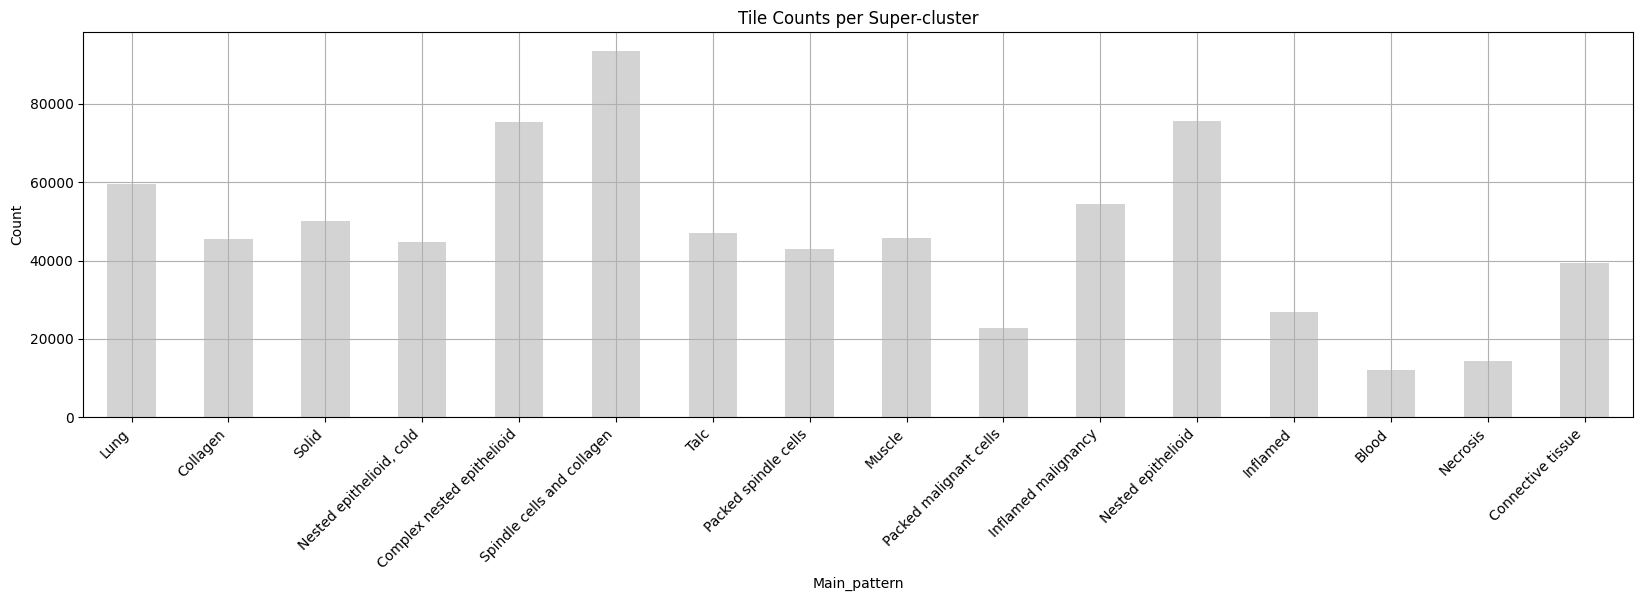

In [23]:
annotations = pd.read_csv('{}/files/meso_annotations_750K.csv'.format(main_path), index_col=0).reset_index()
annotations['main_pattern'] = annotations['main_pattern'].apply(lambda x: x.capitalize())

# adata_train.obs['main_pattern'] = adata_train.obs['leiden_2.0'].apply(lambda x: annotations[annotations['HPC'].astype(str) == x]['main_pattern'].values[0])
# print('Main pattern:', adata_train.obs['main_pattern'].unique())

adata_train.obs['main_pattern'] = adata_train.obs['leiden_2.0'].apply(lambda x: annotations[annotations['HPC'].astype(str) == x]['main_pattern'].values[0])
main_pattern_list = adata_train.obs['main_pattern'].unique()
print('main_pattern:', main_pattern_list)
hpc_groupedby_category = adata_train.obs.groupby('main_pattern')
temp = []
for pattern in main_pattern_list:
    temp.append([pattern, hpc_groupedby_category.get_group(pattern).shape[0], np.unique(hpc_groupedby_category.get_group(pattern)['leiden_2.0'].values, return_counts=True)[0].tolist()])

catg_cluster_df = pd.DataFrame(temp, columns=['Main_pattern', 'Count', 'Clusters'])
fig, ax = plt.subplots(figsize=(20,5))
catg_cluster_df.plot.bar(x='Main_pattern', y='Count', rot=90, fontsize=10, legend=False, title='Tile Counts per Super-cluster', ylabel='Count', grid=True, ax=ax, color='lightgrey')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
plt.savefig(os.path.join(figure_path, 'tile_counts_per_super_cluster.png'), bbox_inches='tight')
# catg_cluster_df.to_csv(os.path.join(figure_path, 'tile_counts_per_super_cluster.csv'), index=False)
display(catg_cluster_df)





In [39]:
import textwrap
sns.set_style("darkgrid")
for spr_clstr in catg_cluster_df.iterrows():    
    im_list = []
    cluster_set = spr_clstr[1]['Clusters']
    for cluster_number in cluster_set:
        indexes, sets = adata_train[adata_train.obs[groupby] == cluster_number].obs['indexes'], adata_train[adata_train.obs[groupby] == cluster_number].obs['original_set']
        i_rand = np.random.randint(0, len(indexes))
        index_ = indexes[i_rand]
        set_ = sets[i_rand]
        if set_ == 'valid': set_address = 'validation' 
        else: set_address = set_
        h5_image_path = h5_complete_path.split('results/')[0] + 'datasets/{}/he/patches_h224_w224/hdf5_Meso_he_{}.h5'.format('Meso', set_address)
        h5_image = h5py.File(h5_image_path, 'r')
        im_list.append((h5_image['{}_img'.format(set_)][int(index_)], cluster_number))
        h5_image.close()

    nrow, ncol = 5, 5
    fig3 = plt.figure(figsize=(6 * ncol, 2 * nrow))
    gs = fig3.add_gridspec(nrow, ncol)

    umap_ncol = 2
    ax1 = fig3.add_subplot(gs[:, 0:umap_ncol])
    sc.pl.umap(adata_train, color=groupby, show=False, ax=ax1, size=5, frameon=False, palette='tab20', legend_fontsize=15, groups=cluster_set, legend_loc='on data', legend_fontoutline = 5, title='')

    ax2 = fig3.add_subplot(gs[0, umap_ncol:ncol-1])
    ax2.set(xticks=[], yticks=[])

    ax2.text(0.5, 0.5, '{}'.format(spr_clstr[1]['Main_pattern']), fontsize=30, ha='center', va='center', weight='bold')
    pos = ax2.get_position()
    ax2.set_position([pos.x0-.02, pos.y0, pos.width, pos.height])


    i,j = 1, ncol-umap_ncol
    for (image, cluster_number) in im_list:
        if j >= ncol:
            j = 3
            i += 1
        
        ax = fig3.add_subplot(gs[i, j])
        ax.set(xticks=[], yticks=[])
        ax.imshow(image)
        j += 1


        ax.set_ylabel('HPC:{}'.format(cluster_number), fontdict=dict(weight='bold', size=22))
        ax.set_axis_on()
        ax.spines['left'].set_color('black')
        ax.spines['right'].set_color('gray')
        ax.spines['top'].set_color('gray')
        ax.spines['bottom'].set_color('gray')
        pos = ax.get_position()
        ax.set_position([pos.x0-.22, pos.y0, pos.width, pos.height])
        ax.text(1.1, .5, textwrap.fill(annotations[annotations['HPC']==int(cluster_number)]['Summary'].values[0],20),
                transform=ax.transAxes,
                horizontalalignment="left", verticalalignment="center", size=18, weight='bold')
    saving_name = 'super_cluster_{}.png'.format(spr_clstr[1]['Main_pattern']).replace('/', '_')
    plt.savefig(os.path.join(figure_path, saving_name), bbox_inches='tight', dpi=300)
    plt.close()



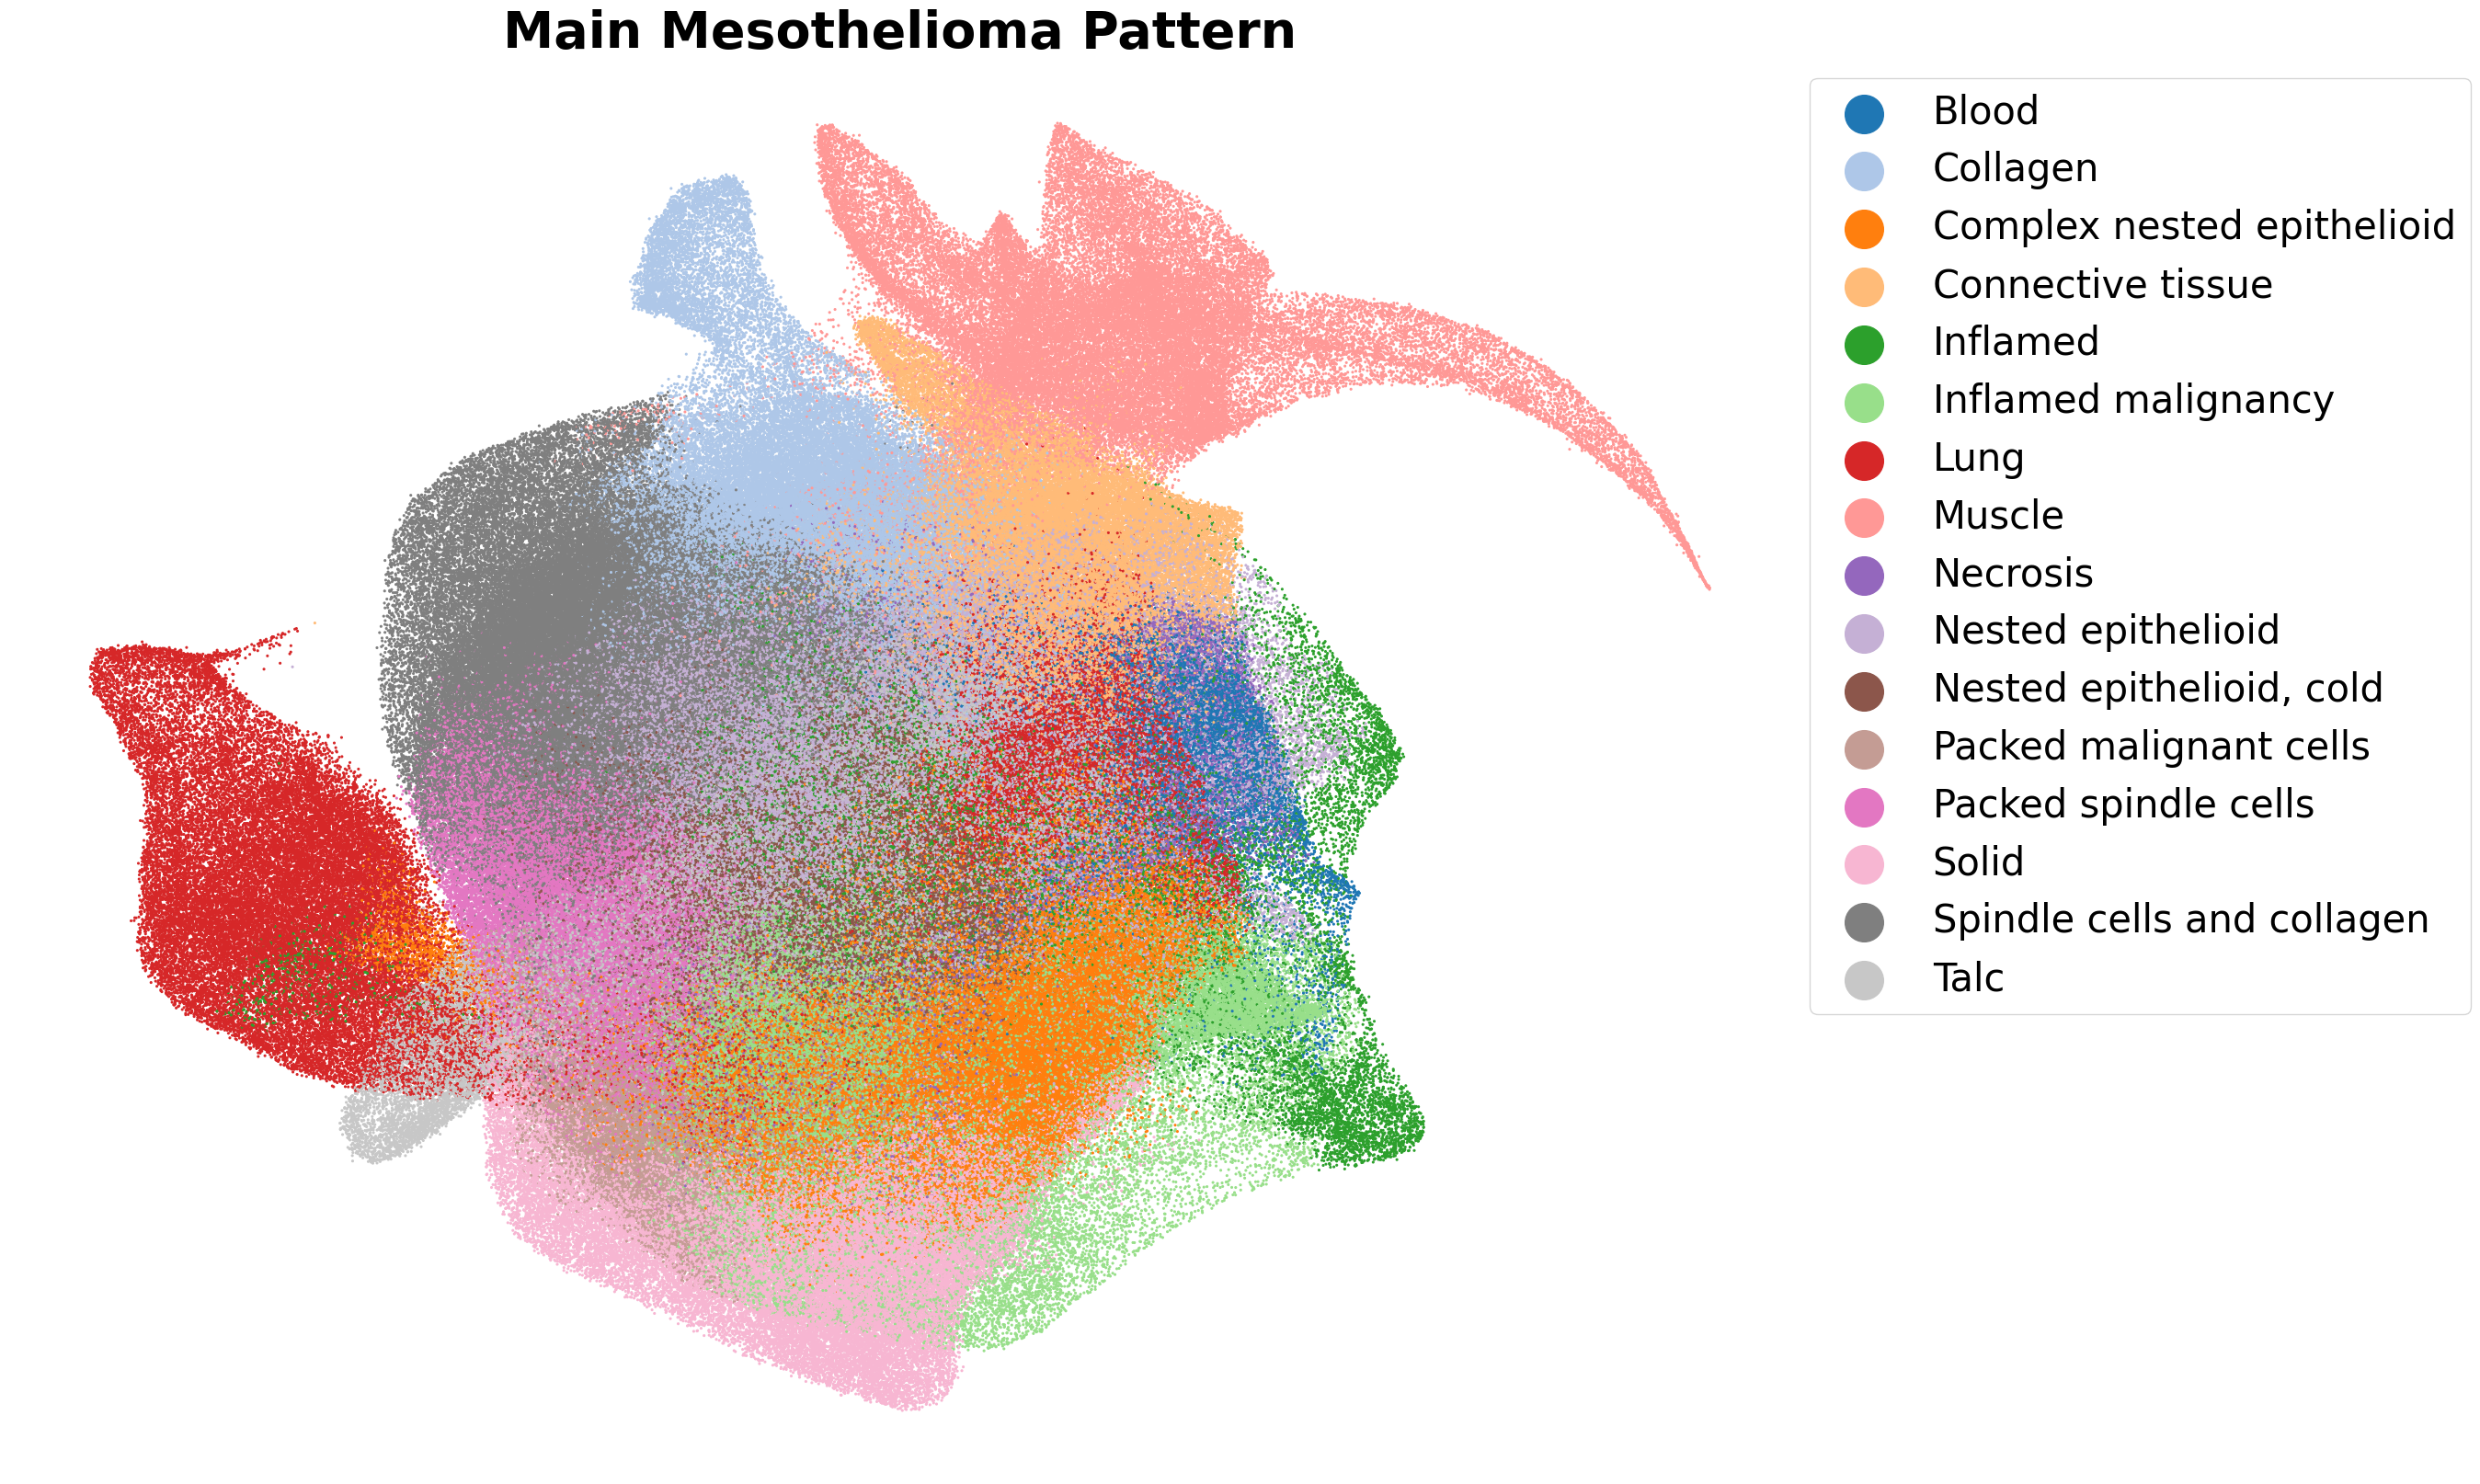

In [9]:
fig = plt.figure(figsize=(25,20))
# sns.set_theme(style='white')
# ax1  = fig.add_subplot(1, 3, 1)
# palette = ['#b4a7d6', '#9380c4', '#795ebf','#4821af']
# sc.pl.umap(adata_train, color='TILS', show=False, size=20,  frameon=False, palette=sns.color_palette(palette), ax=ax1, legend_fontsize=30)
# ax1.set_title('Tumor-infiltrating lymphocyte Degree', fontsize=40, fontweight='bold')
# ax1.legend(markerscale=5, loc='upper left', bbox_to_anchor=(1, 1), fontsize=30)
colors = sns.color_palette('tab20', len(main_pattern_list))

ax2  = fig.add_subplot(1, 1, 1)
sc.pl.umap(adata_train, color='main_pattern', show=False, size=20,  frameon=False, palette=colors , ax=ax2, legend_fontsize=30)
ax2.set_title('Main Mesothelioma Pattern', fontsize=40, fontweight='bold')
ax2.legend(markerscale=5, loc='upper left', bbox_to_anchor=(1, 1), fontsize=30)

# ax3  = fig.add_subplot(1, 3, 3)
# sc.pl.umap(adata_train, color='category', show=False, size=15,  frameon=False, palette='tab20b', ax=ax3)
# ax3.set_title('Mesothelioma Category (Super-Cluster)', fontsize=40, fontweight='bold')
# ax3.legend(markerscale=5, loc='upper left', bbox_to_anchor=(1, 1), fontsize=30)
plt.savefig(os.path.join(figure_path, 'til_pttrn_sprclstr_umap.png'), bbox_inches='tight', dpi=300)



# WSI visualization

Use the saved processed csvs for new plots if required, here: results/BarlowTwins_3/Meso_400_subsampled/h224_w224_n3_zdim128/meso_subtypes_nn400/leiden_2p0_fold0/figures

In [49]:
whole_dataset = 'Meso'
h5_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_metadata.h5'.format(main_path, whole_dataset, whole_dataset)
adatas_path_whole = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/meso_subtypes_nn400/adatas'.format(main_path, whole_dataset)
annotations = pd.read_csv('%s/files/Meso_400_subsampled_annotations.csv'%main_path)
annotations.head(5)

HPC                                            Summary    category   
0    0  Cellular reactive stroma with very occasional ...      Tumour  \
1    1                    Hyalinised paucicellular stroma  Non-tumour   
2    2                         Fibrin and granular debris  Non-tumour   
3    3  Some stroma, some sarcomatoid, some epithelioi...      Tumour   
4    4                                     Adipose tissue  Non-tumour   

  main_pattern  
0  Epithelioid  
1   Non-tumour  
2   Non-tumour  
3        Mixed  
4   Non-tumour

In [ ]:
# Dataset images.
from data_manipulation.data import Data
data = Data(dataset=whole_dataset, marker='he', patch_h=224, patch_w=224, n_channels=3, batch_size=64, project_path=main_path, load=True)
data_dicts = dict()

data_dicts['train'] = data.training.images
data_dicts['valid'] = data.validation.images
data_dicts['test']  = data.test.images

value_cluster_ids = dict()
value_cluster_ids[0] = []
value_cluster_ids[1] = [1]
only_id = True

# Read frames.
_, frame_whole, leiden_clusters_whole = read_csvs(adatas_path_whole, matching_field, groupby, fold_number, [[],[],[]], h5_path, None, additional_as_fold=False, force_fold=None)
colors = sns.color_palette('tab20', len(leiden_clusters_whole))
frame_whole['Meso_type'] = frame_whole['type'].apply(lambda x: 0 if x == 'Epithelioid' else 1)
slide_rep_df_whole = prepare_set_representation(frame_whole, matching_field, meta_field, groupby, leiden_clusters, type_='clr', min_tiles=100)

dropped_slides = ['MESO_471_1', 'MESO_471_2', 'MESO_471_3','MESO_322_16', 'MESO_46_7']
slide = dropped_slides[-2]
from models.visualization.clusters import get_wsi_arrays
wsi, wsi_c, slide_clusters = get_wsi_arrays(frame_whole, groupby, slide, img_size=224, downsample=2, img_dicts=data_dicts, colors=colors, pad_pixels=0, legend_margin=1000)
frame_whole


In [60]:
slide_rep_df_whole.to_csv(figure_path + '/%s_%s_slide_representations.csv' % (whole_dataset, meta_folder), index=True)
frame_whole.to_csv(figure_path + '/%s_%s_frame_representations.csv' % (whole_dataset, meta_folder), index=True)

In [ ]:
from models.visualization.clusters import get_wsi_arrays
from matplotlib.lines        import Line2D

for slide in dropped_slides:
    wsi, wsi_c, slide_clusters = get_wsi_arrays(frame_whole, groupby, slide, img_size=224, downsample=2, img_dicts=data_dicts, colors=colors, pad_pixels=0, legend_margin=1000)
    fontsize   = 30
    markersize = 15


    image_clusters, counts = np.unique(slide_clusters, return_counts=True)
    custom_lines = [Line2D([0], [0], color=colors[image_clusters[index]], lw=markersize) for index in np.argsort(-counts)]
    names_lines  = []
    for index in np.argsort(-counts):
        hpc = image_clusters[index]
        name = 'HPC %2s - Area(%s) %3s - %s' % (hpc, '%', np.round(slide_rep_df_whole.loc[slide,hpc]*100,1), annotations.loc[hpc, 'Summary'])
        names_lines.append(name)

    for (_wsi, wsi_name) in [(wsi,'wsi'), (wsi_c,'wsi_c')]:
        dpi = 100
        height, width, _ = _wsi.shape
        figsize = width / float(dpi), height / float(dpi)
        fig = plt.figure(figsize=figsize)
        ax  = fig.add_subplot(1, 1, 1)
        ax.imshow(_wsi/255.)
        ax.axis('off')


        legend = ax.legend(custom_lines, names_lines, title='Histomorphological Phenotype Cluster\n(HPC)', frameon=False, loc='lower left', 
                        prop={'weight':'bold', 'size':fontsize}, title_fontproperties={'weight':'bold', 'size':fontsize*1.1}, bbox_to_anchor=(.87, .4))

        # plt.show(fig)
        # save figure
        fig.savefig(figure_path + '/%s_%s_%s_legend.jpg' % (whole_dataset, meta_folder, wsi_name), bbox_inches='tight', pad_inches=0)


# gc.collect()

### Annotation Tables

In [1]:
import pandas as pd
import numpy as np

main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
figure_path = main_path + '/workflow/figures/HPC_figures/'
df1 = pd.read_excel(f'{main_path}/files/MM_cluster_annotation_form_v1_CR.xlsx', sheet_name='Sheet1', header=50, usecols='B:Y')
df1.iloc[-1, 0] = 46
df1.columns = [x+'_1' for x in df1.columns]
df1.rename(columns={'Cluster_1': 'HPC'}, inplace=True)

df2 = pd.read_excel(f'{main_path}/files/MM_cluster_annotation_form_v1_JLQ.xlsx', sheet_name='Sheet1', header=50, usecols='B:Y')
df2.columns = [x+'_2' for x in df2.columns]
df2.rename(columns={'Cluster_2': 'HPC'}, inplace=True)

df3 = pd.read_excel(f'{main_path}/files/MM_cluster_annotation_form_v1_SK.xlsx', sheet_name='Sheet1', header=50, usecols='B:Y')
df3.columns = [x+'_3' for x in df3.columns]
df3.rename(columns={'Cluster_3': 'HPC'}, inplace=True)

df_total = pd.merge(df1, df2, on='HPC', how='inner')
df_total = pd.merge(df_total, df3, on='HPC', how='inner')
df_total = df_total.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)

# df_total.to_csv(f'{figure_path}/meso_cluster_annotations.csv', index=False)
# df_total.columns

In [2]:
# Guide for the annotation.
def clean_array(x):
    xp = []
    for i in x:
        if not isinstance(i, float): 
            xp.append(i)
            # remove white spaces.
            xp = [x.strip() for x in xp]
    xp = list(set(xp))
    return np.array(xp)

def list_to_string(x):
    if len(x) == 1:
        return x[0]
    elif len(x) == 2:
        return x[0] + ' (-)'
    else:
        return ', '.join(x)

option1_df = pd.read_excel(f'{main_path}/files/MM_cluster_annotation_form_v1_CR.xlsx', sheet_name='Sheet1', header=5, nrows=9)
option1_df['Types'] = [clean_array(x) for x in option1_df[['Options', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10']].to_numpy()]
option1_df = option1_df.drop(['Unnamed: 0', 'Unnamed: 4', 'Option 1 - Epithelioid tumour', 'Unnamed: 2', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Options'], axis=1)


option2_df = pd.read_excel(f'{main_path}/files/MM_cluster_annotation_form_v1_CR.xlsx', sheet_name='Sheet1', header=17, nrows=8)
option2_df['Types'] = [clean_array(x) for x in option2_df[['Options', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10']].to_numpy()]
option2_df = option2_df.drop(['Unnamed: 0', 'Unnamed: 4', 'Option 2 - Spindle cells / extracellular matrix', 'Unnamed: 2', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Options'], axis=1)

option3_df = pd.read_excel(f'{main_path}/files/MM_cluster_annotation_form_v1_CR.xlsx', sheet_name='Sheet1', header=28, nrows=6)
option3_df['Types'] = [clean_array(x) for x in option3_df[['Options', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13']].to_numpy()]
option3_df = option3_df.drop(['Unnamed: 0', 'Unnamed: 4', 'Option 3 - Non-tumour', 'Unnamed: 2', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Options'], axis=1)

# Save the annotation guide.
# option1_df.to_csv(f'{figure_path}/option1.csv', index=False)
# option2_df.to_csv(f'{figure_path}/option2.csv', index=False)
# option3_df.to_csv(f'{figure_path}/option3.csv', index=False)
display(option1_df)
display(option2_df)
display(option3_df)


Topic   
0  Predominant architectural growth pattern  \
1           Second most predominant pattern   
2                            Nuclear atypia   
3                             Inflammation*   
4                                Necrosis**   
5                       Stroma:Tumour ratio   
6                    Stromal cellularity***   
7                       ^Biphasic features?   
8        Other notable features or comments   

                                               Types  
0  [Micropapillary, Papillary, Trabecular, Adenom...  
1  [Micropapillary, Papillary, Trabecular, Adenom...  
2                      [None/mild, Moderate, Severe]  
3               [Mild-moderate, Marked, None-sparse]  
4                            [None, Some, Universal]  
5          [More stroma, Roughly equal, More tumour]  
6                              [Moderate, Low, High]  
7                                          [No, Yes]  
8                            [free text/annotations]

Topic   
0                                      Cellularity  \
1                                     Architecture   
2  Presence of desmoplastic sarcomatoid morphology   
3                                   Nuclear atypia   
4                                    Inflammation*   
5                                       Necrosis**   
6                              ^Biphasic features?   
7               Other notable features or comments   

                                               Types  
0                                [Medium, Low, High]  
1  [Orderly (parallel), Disorderly (random/storif...  
2                                  [Absent, Present]  
3                      [None/mild, Moderate, Severe]  
4               [Mild-moderate, Marked, None-sparse]  
5                            [None, Some, Universal]  
6                                          [No, Yes]  
7                            [free text/annotations]

Topic   
0        Tiles contain mostly (by area)  \
1  Second most common feature (by area)   
2                         Inflammation*   
3                            Necrosis**   
4    Other notable features or comments   

                                               Types  
0  [Haemorrhage, Other (please specify), Cartilag...  
1  [Haemorrhage, Other (please specify), Cartilag...  
2               [Mild-moderate, Marked, None-sparse]  
3                            [None, Some, Universal]  
4                            [free text/annotations]

In [39]:
voting_df = pd.DataFrame()

# Infllamation degree.
Inflammation = df_total[['Inflammation*_1', 'Inflammation*.1_1', 'Inflammation*.2_1', 'Inflammation*_2', 'Inflammation*.1_2', 'Inflammation*.2_2', 'Inflammation*_3', 'Inflammation*.1_3', 'Inflammation*.2_3' ]]
voting_df['inflammation'] = [clean_array(x) for x in Inflammation.mode(axis=1)[[0,1,2]].to_numpy()]


# Necrosis degree.
Necrosis = df_total[['Necrosis**_1', 'Necrosis**.1_1', 'Necrosis**.2_1', 'Necrosis**_2', 'Necrosis**.1_2', 'Necrosis**.2_2', 'Necrosis**_3', 'Necrosis**.1_3', 'Necrosis**.2_3' ]]
voting_df['necrosis'] = [clean_array(x) for x in Necrosis.mode(axis=1)[[0,1]].to_numpy()]


# Stromal cellularity degree.
Stromal_cellularity = df_total[['Stromal cellularity***_1', 'Stromal cellularity***_2', 'Stromal cellularity***_3']]
voting_df['stromal_cellularity'] = [clean_array(x) for x in Stromal_cellularity.mode(axis=1)[[0,1]].to_numpy()]

# epith_growth_pattern.
epith_growth_pattern = df_total[['Predominant architectural growth pattern_1', 'Second most predominant pattern_1', 'Predominant architectural growth pattern_2', 'Second most predominant pattern_2', 'Predominant architectural growth pattern_3', 'Second most predominant pattern_3']]
voting_df['epith_growth_pattern'] = [clean_array(x) for x in epith_growth_pattern.mode(axis=1)[[0,1]].to_numpy()]

# spindle tiles architecture.
spindle_arch = df_total[['Architecture_1', 'Architecture_2', 'Architecture_3']]
voting_df['spindle_arch'] = [clean_array(x) for x in spindle_arch.mode(axis=1)[[0,1,2]].to_numpy()]

spidle_cellularity = df_total[['Cellularity_1', 'Cellularity_2', 'Cellularity_3']]
voting_df['spindle_cellularity'] = [clean_array(x) for x in spidle_cellularity.mode(axis=1)[[0,1]].to_numpy()]

desmoplastic_component = df_total[['Desmoplastic_1', 'Desmoplastic_2', 'Desmoplastic_3']]
voting_df['desmoplastic_component'] = [clean_array(x) for x in desmoplastic_component.mode(axis=1)[[0]].to_numpy()]

# Non-tumour tiles architecture.
non_tumour_tiles = df_total[['Tiles contain mostly (by area)_1', 'Second most common feature (by area)_1', 'Tiles contain mostly (by area)_2', 'Second most common feature (by area)_2', 'Tiles contain mostly (by area)_3', 'Second most common feature (by area)_3']]
voting_df['non_tumour_tiles'] = [clean_array(x) for x in non_tumour_tiles.mode(axis=1)[[0,1,2,3]].to_numpy()]

# Nuclear atypia degree.
Nuclear_atypia = df_total[['Nuclear atypia_1', 'Nuclear atypia.1_1', 'Nuclear atypia_2', 'Nuclear atypia.1_2', 'Nuclear atypia_3', 'Nuclear atypia.1_3']]
voting_df['nucl_atypia'] = [clean_array(x) for x in Nuclear_atypia.mode(axis=1)[[0,1,2]].to_numpy()]

# Percentage cluster purity
cluster_purity = df_total[['Percentage cluster purity_1', 'Percentage cluster purity_2', 'Percentage cluster purity_3']]
voting_df['cluster_purity'] = [clean_array(x) for x in cluster_purity.mode(axis=1)[[0,1,2]].to_numpy()]

voting_df = voting_df.applymap(lambda x: list_to_string(x))
voting_df.to_csv(figure_path + '/annotation_voting_df.csv', index=True)
display(voting_df)

inflammation   necrosis stromal_cellularity   
0   Mild-moderate, None-sparse, Marked       None                      \
1                               Marked       None                       
2                          None-sparse       None                       
3                          None-sparse       None                       
4                          None-sparse       None                       
5                          None-sparse       None                       
6                        Mild-moderate       None                 Low   
7                               Marked       None            High (-)   
8                          None-sparse       None                 Low   
9                          None-sparse       None                       
10                         None-sparse       None                 Low   
11                         None-sparse       Some                       
12                         None-sparse       None                       
13                         None-sparse       None                       
14                         None-sparse       None                 Low   
15                         None-sparse       None                       
16                       Mild-moderate       None                       
17                         None-sparse       None                       
18                         None-sparse  Universal                 Low   
19                         None-sparse       None                       
20                       Mild-moderate       None                 Low   
21                         None-sparse       None                       
22                       Mild-moderate       None                       
23                         None-sparse       None                       
24                       Mild-moderate       None                 Low   
25                       Mild-moderate       None                 Low   
26                         None-sparse       None                       
27                              Marked       None                 Low   
28                         None-sparse       None                       
29                              Marked       Some            Moderate   
30                       Mild-moderate       None                       
31                         None-sparse       None                       
32                         None-sparse       None                       
33                         None-sparse       None             Low (-)   
34                         None-sparse       None                       
35                         None-sparse       None                 Low   
36                         None-sparse       None                       
37                         None-sparse       None            Moderate   
38                         None-sparse       None                       
39                         None-sparse       None            Moderate   
40                       Mild-moderate       Some            Moderate   
41                              Marked       Some                       
42                         None-sparse       None            Moderate   
43                       Mild-moderate       None                 Low   
44                         None-sparse       None            Moderate   
45                         None-sparse       None                       
46                         None-sparse       Some                       

   epith_growth_pattern                                       spindle_arch   
0                                            Disorderly (random/storiform)  \
1                                                                            
2                                                                            
3                                                       Orderly (parallel)   
4                                                                            
5                                                    

In [146]:
# define __missing__ for dict
class DefaultDict(dict):
    def __missing__(self, key):
        return key
    
inf_di = DefaultDict({'None-sparse':1, 'Mild-moderate':2, 'Marked':3})
nec_di = DefaultDict({'None':1, 'Some':2, 'Universal':3})
strm_cl_di = DefaultDict({'Low':1, 'Moderate':2, 'High':3})
epi_grwth_pttr_di = DefaultDict({'Tubular':1, 'Solid':3, 'Micropapillary':2, 'Adenomaotoid':5, 'Papillary':4, 'Trabecular':6})
spindle_arch_di = DefaultDict({'Orderly (parallel)':1, 'Less orderly (eg wavy)':2, 'Disorderly (random/storiform)':3})
spindle_cel_di = DefaultDict({'Low':1, 'Medium':2, 'High':3})
desmoplastic_di = DefaultDict({'Absent':1, 'Present':2})
nucl_attypia_di = DefaultDict({'None/mild':1, 'Moderate':2, 'Severe':3})
clust_purity_di = DefaultDict({'Low (< 50%)':1, 'Moderate (50 - 75%)':2, 'High (> 75%)':3})

temp = voting_df[['inflammation', 'necrosis', 'stromal_cellularity', 'epith_growth_pattern', 'spindle_arch', 'spindle_cellularity', 'desmoplastic_component', 'nucl_atypia', 'cluster_purity']]
temp['inflammation'] = temp['inflammation'].map(inf_di)
temp['necrosis'] = temp['necrosis'].map(nec_di)
temp['stromal_cellularity'] = temp['stromal_cellularity'].map(strm_cl_di)
temp['epith_growth_pattern'] = temp['epith_growth_pattern'].map(epi_grwth_pttr_di)
temp['spindle_arch'] = temp['spindle_arch'].map(spindle_arch_di)
temp['spindle_cellularity'] = temp['spindle_cellularity'].map(spindle_cel_di)
temp['desmoplastic_component'] = temp['desmoplastic_component'].map(desmoplastic_di)
temp['nucl_atypia'] = temp['nucl_atypia'].map(nucl_attypia_di)
# temp['cluster_purity'] = temp['cluster_purity'].map(clust_purity_di)
temp = temp.applymap(lambda x: -1 if isinstance(x, str) and x!='' else x)
temp['cluster_purity'] = voting_df['cluster_purity']
temp = temp.applymap(lambda x: 0 if x=='' else x)

temp

inflammation  necrosis  stromal_cellularity  epith_growth_pattern   
0             -1         1                    0                     0  \
1              3         1                    0                     0   
2              1         1                    0                     0   
3              1         1                    0                     0   
4              1         1                    0                     0   
5              1         1                    0                     0   
6              2         1                    1                    -1   
7              3         1                   -1                     3   
8              1         1                    1                     1   
9              1         1                    0                     0   
10             1         1                    1                     1   
11             1         2                    0                     0   
12             1         1                    0                     0   
13             1         1                    0                     0   
14             1         1                    1                     1   
15             1         1                    0                     0   
16             2         1                    0                     0   
17             1         1                    0                     0   
18             1         3                    1                     3   
19             1         1                    0                     0   
20             2         1                    1                     1   
21             1         1                    0                     0   
22             2         1                    0                     0   
23             1         1                    0                     0   
24             2         1                    1                    -1   
25             2         1                    1                     3   
26             1         1                    0                     0   
27             3         1                    1                    -1   
28             1         1                    0                     0   
29             3         2                    2                     1   
30             2         1                    0                     0   
31             1         1                    0                     0   
32             1         1                    0                     0   
33             1         1                   -1                     1   
34             1         1                    0                     0   
35             1         1                    1                     3   
36             1         1                    0                     0   
37             1         1                    2                     1   
38             1         1                    0                     0   
39             1         1                    2                    -1   
40             2         2                    2                     3   
41             3         2                    0                     0   
42             1         1                    2                     1   
43             2         1                    1                     4   
44             1         1                    2                     4   
45             1         1                    0                     0   
46             1         2                    0                     0   

    spindle_arch  spindle_cellularity  desmoplastic_component  nucl_atypia   
0              3                    3                       1            1  \
1              0                    0                       0            0   
2              0                    0                       0            0   
3              1                    1                       1            1   
4              0                    0                       0            0   
5              0               

### Load WSI

In [20]:
from skimage.transform import resize
''' ###### Visualize WSI Cluster Samples ######### '''
def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image


# Get tile information.
def get_x_y(tile_info):
    if '.' in str(tile_info):
        string = tile_info.split('.')[0]
    else:
        string = str(tile_info)
    # if TCGA-MESO put - instead of _.
    x, y   = string.split('_')
    return int(x),int(y)
    
def get_wsi_arrays(frame, groupby, slide, img_size, downsample, img_dicts, colors, pad_pixels=50, legend_margin=1000):
    slide_indices  = frame[frame[matching_field]==slide].indexes.values.tolist()
    slide_tiles    = frame[frame[matching_field]==slide].tiles.values.tolist()
    slide_sets     = frame[frame[matching_field]==slide].original_set.values.tolist()
    slide_clusters = frame[frame[matching_field]==slide][groupby].values.tolist()

    # Get size of the WSI.
    # print('\t\tSlide %s: %s' % (slide, len(slide_indices)))
    y,x = get_x_y(slide_tiles[0])
    x_min = x
    x_max = x
    y_min = y
    y_max = y
    for i in slide_tiles:
        y_i, x_i  = get_x_y(i)
        x_min = min(x_min, x_i)
        y_min = min(y_min, y_i)
        x_max = max(x_max, x_i)
        y_max = max(y_max, y_i)
    x_max += 1
    y_max += 1

    wsi_x = int(x_max*img_size//downsample)
    wsi_y = int(y_max*img_size//downsample)

    # Original 5x.
    wsi   = np.ones((wsi_x, wsi_y, 3), dtype=np.uint8)*255
    wsi_c = np.ones((wsi_x, wsi_y, 3), dtype=np.uint8)*255
    print('\t\tWhole Slide Image Resolution %s: (%s, %s)' % (slide, wsi_x, wsi_y))

    for index, tile, original_set, cluster in zip(slide_indices, slide_tiles, slide_sets, slide_clusters):
        y_i, x_i  = get_x_y(tile)
        x_i *= img_size//downsample
        y_i *= img_size//downsample
        tile_img = img_dicts[original_set][int(index)]
        tile_img = np.array(resize(tile_img, (tile_img.shape[0]//downsample, tile_img.shape[1]//downsample), anti_aliasing=True), dtype=float)
        tile_img = (tile_img*255).astype(np.uint8)

        if cluster == 'Others':
            # color = colors[-1]
            # color = colors[cluster]
            color = (1.0, 1.0, 1.0)
        else:
            # color = colors[int(cluster)]
            color = colors[cluster]
        mask  = np.ones((img_size//downsample,img_size//downsample))

        wsi[x_i:x_i+(img_size//downsample), y_i:y_i+(img_size//downsample), :]   = tile_img
        wsi_c[x_i:x_i+(img_size//downsample), y_i:y_i+(img_size//downsample), :] = apply_mask(tile_img, mask, color, alpha=0.5)

    wsi_padded = np.pad(wsi[:, :, 0], ((pad_pixels, pad_pixels), (pad_pixels, pad_pixels+legend_margin)), 'maximum')
    wsi_padded_total = np.zeros(list(wsi_padded.shape) + [3])
    wsi_padded_total[:, :, 0] = wsi_padded
    wsi_padded_total[:, :, 1] = np.pad(wsi[:, :, 1], ((pad_pixels, pad_pixels), (pad_pixels, pad_pixels+legend_margin)), 'maximum')
    wsi_padded_total[:, :, 2] = np.pad(wsi[:, :, 2], ((pad_pixels, pad_pixels), (pad_pixels, pad_pixels+legend_margin)), 'maximum')

    wsi_padded = np.pad(wsi_c[:, :, 0], ((pad_pixels, pad_pixels), (pad_pixels, pad_pixels+legend_margin)), 'maximum')
    wsi_c_padded_total = np.zeros(list(wsi_padded.shape) + [3])
    wsi_c_padded_total[:, :, 0] = wsi_padded
    wsi_c_padded_total[:, :, 1] = np.pad(wsi_c[:, :, 1], ((pad_pixels, pad_pixels), (pad_pixels, pad_pixels+legend_margin)), 'maximum')
    wsi_c_padded_total[:, :, 2] = np.pad(wsi_c[:, :, 2], ((pad_pixels, pad_pixels), (pad_pixels, pad_pixels+legend_margin)), 'maximum')
    return wsi_padded_total, wsi_c_padded_total, slide_clusters


In [23]:
# Images
main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
import sys
import h5py
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append(main_path)
from data_manipulation.data import Data
# data = Data(dataset='TCGA_MESO', marker='he', patch_h=224, patch_w=224, n_channels=3, batch_size=64, project_path=main_path, load=True)
data = Data(dataset='Meso', marker='he', patch_h=224, patch_w=224, n_channels=3, batch_size=64, project_path=main_path, load=True)
data_dicts = dict()

data_dicts['train'] = data.training.images
data_dicts['valid'] = data.validation.images
data_dicts['test']  = data.test.images

Meso


In [22]:
# h5_file = '/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/TCGA_MESO/h224_w224_n3_zdim128/hdf5_TCGA_MESO_he_complete.h5'
h5_file = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/hdf5_Meso_he_complete.h5'
h5_image = h5py.File(h5_file, 'r')
df = pd.DataFrame()
df['indexes'] = h5_image['indexes'][:].astype(int)
df['slides'] = h5_image['slides'][:].astype(str)
df['tiles'] = h5_image['tiles'][:].astype(str)
df['original_set'] = h5_image['original_set'][:].astype(str)

In [21]:
# frame_cluster = pd.read_csv('/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/750K/adatas/TCGA_MESO_he_complete_filtered_metadata_leiden_2p0__fold4.csv')
frame_cluster = pd.read_csv('/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/750K/adatas/Meso_he_complete_filtered_metadata_leiden_2p0__fold4.csv')
df_tile_slide_set = frame_cluster[['leiden_2.0','slides', 'tiles']]

/tmp/ipykernel_3279207/1726002835.py:2: DtypeWarning: Columns (12,28) have mixed types. Specify dtype option on import or set low_memory=False.
  frame_cluster = pd.read_csv('/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/750K/adatas/Meso_he_complete_filtered_metadata_leiden_2p0__fold4.csv')


In [62]:
df_tile_slide_set[df_tile_slide_set['leiden_2.0']==10].groupby('slides').size().sort_values(ascending=True)

slides
MESO_297_13      12
MESO_5_8         12
MESO_5_11        12
MESO_5_10        12
MESO_6_9         12
               ... 
MESO_372_16     316
MESO_61_16      370
MESO_61_26      400
MESO_372_5      684
MESO_372_6     1057
Length: 1124, dtype: int64

In [16]:
frame_cluster_epithelioid = frame_cluster[frame_cluster['type']=='Epithelioid']
frame_cluster_epithelioid[frame_cluster_epithelioid['leiden_2.0']==22].groupby('slides').size().sort_values(ascending=True)[-10:] #for the sarc/biphasic cluster in epithelioid cases

slides
MESO_337_7     267
MESO_373_1     286
MESO_387_26    290
MESO_387_28    295
MESO_387_24    304
MESO_387_27    312
MESO_20_8      316
MESO_78_11     435
MESO_388_13    630
MESO_357_5     647
dtype: int64

In [32]:
groupby = 'leiden_2.0'
# Id = 'TCGA-UD-AAC4'
Id = 280
figure_path = main_path + '/workflow/figures/HPC_figures/'
slides = frame_cluster[frame_cluster['case_Id'] == Id].slides.unique()
print('Slides:', slides)
# case_Id = slides[1]
# case_Id = 'MESO_372_5'
case_Id = 'MESO_191_12'
matching_field = 'slides'
temp = df_tile_slide_set[df_tile_slide_set[matching_field] == case_Id]
top_hpcs = temp[groupby].value_counts().head(10)
temp = temp[temp[groupby].isin(top_hpcs.index.values)]

case_Id_df = df[df[matching_field] == case_Id]
case_Id_df = case_Id_df.merge(temp, on=['slides', 'tiles'], how='outer')
case_Id_df[groupby] = case_Id_df[groupby].fillna('Others')

# colors
colors = sns.color_palette('tab20', len(top_hpcs)+1)
color_map = dict(zip(top_hpcs.index.tolist(), colors))

Slides: ['MESO_280_23' 'MESO_280_19' 'MESO_280_25' 'MESO_280_26' 'MESO_280_20'
 'MESO_280_18']


In [ ]:
wsi, wsi_c, slide_clusters = get_wsi_arrays(case_Id_df, groupby, case_Id, img_size=224, downsample=2, img_dicts=data_dicts, colors=color_map, pad_pixels=0, legend_margin=100)
fontsize   = 30
markersize = 15
image_clusters, counts = np.unique(slide_clusters, return_counts=True)

		Whole Slide Image Resolution MESO_191_12: (5376, 5936)


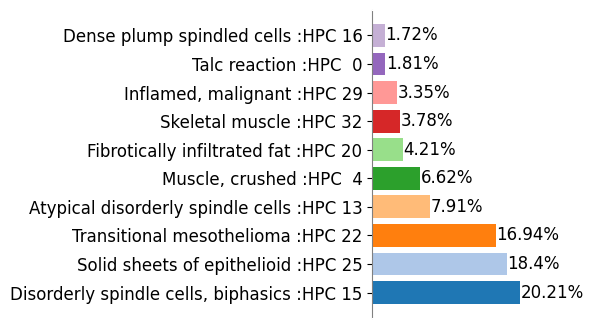

In [34]:
# import textwrap
annotations = pd.read_csv('{}/files/meso_annotations_750K.csv'.format(main_path), index_col=0).reset_index()
plt_labels, plt_colors = [], []
for hpc in top_hpcs.index.tolist():
    color = color_map[hpc]       
    # ann_hpc = textwrap.fill(annotations[annotations['HPC'] == hpc]['Summary'].values[0] + ' ({})'.format(annotations[annotations['HPC'] == hpc]['main_pattern'].values[0]), width=80)
    ann_hpc = annotations[annotations['HPC'] == hpc]['Summary'].values[0]
    ratio = case_Id_df[case_Id_df[groupby]==hpc].shape[0]/case_Id_df.shape[0]
    name = '%s :HPC %2s' % (ann_hpc, hpc)
    plt_labels.append(name)
    plt_colors.append(color)


fig = plt.figure(figsize=(2,4))
ax = fig.add_subplot(1, 1, 1)
ax.barh(range(len(top_hpcs.values)), top_hpcs.values, color=plt_colors)
for i, v in enumerate(top_hpcs.values):
    ax.text(v+1, i, str(np.round(v/sum(counts)*100, 2)) + '%', ha='left', va='center', fontsize=12)
ax.set_yticks(range(len(top_hpcs.values)), plt_labels);
plt.setp(ax.get_yticklabels(), fontsize=12)
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.get_xaxis().set_visible(False)
plt.savefig(f'{figure_path}/top_hpcs_{case_Id}.png', bbox_inches='tight', dpi=300)

In [29]:
# fig = plt.figure(figsize=(30,30))
for (_wsi, wsi_name) in [(wsi,'wsi'), (wsi_c,'wsi_overlay')]:
    dpi = 100
    height, width, _ = _wsi.shape
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(1, 1, 1) 
    ax.imshow(_wsi/255.)
    ax.axis('off')

    # plt.show(fig)
    plt.savefig(f'{figure_path}/trans_meso/{wsi_name}_{case_Id}.png', bbox_inches='tight', dpi=dpi)
    plt.close(fig)

### Tile Images

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
import sys
sys.path.append(main_path)
from models.clustering.data_processing import *

h5_complete_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, 'Meso', 'Meso')
meta_folder = '750K'
groupby = 'leiden_2.0'
fold_number = 4
figure_path = main_path + '/workflow/figures/HPC_figures/'
adata_train, h5ad_path = read_h5ad_reference(h5_complete_path, meta_folder, groupby, fold_number)



In [2]:
annotations = pd.read_csv('{}/files/meso_annotations_750K.csv'.format(main_path), index_col=0).reset_index()
annotations
# 

index  HPC                                      Summary   
0       0    0                                Talc reaction  \
1       1    1       Inflamed fat, sparse epithelioid nests   
2       2    2                              Compressed lung   
3       3    3         Sparsely cellular connective tissues   
4       4    4                              Muscle, crushed   
5       5    5                            Lung with vessels   
6       6    6                      Inflamed solid/spindled   
7       7    7          Heavily inflamed diverse malignancy   
8       8    8            Tubulopapillary epithelioid, cold   
9       9    9                                    Open lung   
10     10   10            Epithelioid nests in bland stroma   
11     11   11  Talc, pleurodesis, epithelioid infiltration   
12     12   12                           Fibrillar collagen   
13     13   13            Atypical disorderly spindle cells   
14     14   14                   Nests and trabeculae, cold   
15     15   15          Disorderly spindle cells, biphasics   
16     16   16                   Dense plump spindled cells   
17     17   17                        Collagen, tiny nuclei   
18     18   18                     Diverse necrotic tissues   
19     19   19                                          Fat   
20     20   20                 Fibrotically infiltrated fat   
21     21   21    Abundant plump disorganised spindle cells   
22     22   22                    Transitional mesothelioma   
23     23   23             Bland spindle cells and collagen   
24     24   24           Sparse inflamed epithelioid tumour   
25     25   25                  Solid sheets of epithelioid   
26     26   26                    Large vessels and airways   
27     27   27                            Dense lymphocytes   
28     28   28                               Pleural plaque   
29     29   29                          Inflamed, malignant   
30     30   30                  Inflamed, fibrotic, diverse   
31     31   31                            Lung with vessels   
32     32   32                              Skeletal muscle   
33     33   33                            Epithelioid nests   
34     34   34                 Skeletal muscle-longitudinal   
35     35   35       Cuboidal epithelioid, diverse patterns   
36     36   36                        Basket-weave collagen   
37     37   37                     Cold, epithelioid, solid   
38     38   38                     Desmoplastic sarcomatoid   
39     39   39            Elongated epithelioid nests, cold   
40     40   40       Solid epithelioid, moderately inflamed   
41     41   41                                        Blood   
42     42   42                              Tubulopapillary   
43     43   43                          Papillary and solid   
44     44   44                   Papillae and micropapillae   
45     45   45                           Muscle, transverse   
46     46   46                          Diathermy and crush   

                  main_pattern  
0                         Talc  
1                     Inflamed  
2                         Lung  
3                     Collagen  
4                       Muscle  
5                         Lung  
6          Inflamed malignancy  
7          Inflamed malignancy  
8     Nested epithelioid, cold  
9                         Lung  
10          Nested epithelioid  
11                        Talc  
12  Spindle cells and collagen  
13  Spindle cells and collagen  
14  Complex nested epithelioid  
15        Packed spindle cells  
16        Packed spindle cells  
17                    Collagen  
18                    Necrosis  
19           Connective tissue  
20          Nested epithelioid  
21        Packed spindle cells  
22      Packed malignant cells  
23  Spindle cells and collagen  
24          Nested epithelioid  
25                       Solid  
26                        Lung  
27                    Inflamed  
28                    

In [ ]:
import textwrap

# cluster_set = ['13', '15', '21', '38']
# fldr_nm = 'desmoplastic_component'

# cluster_set = ['18']
# cluster_set = ['11', '29', '40', '41', '46']
# fldr_nm = 'necrosis'

# cluster_set = ['1','7','27','29', '41']
# fldr_nm = 'marked_inflammation'


# cluster_set = ['0','7','16','21','22']
# fldr_nm = 'spindle_cellularity'


# cluster_set = ['29','37','39','40','44','42']
# fldr_nm = 'epith_moderate_stromal_cellularity'

# cluster_set = [str(x) for x in range(0, 47)]
cluster_set = ['4']
fldr_nm = 'all_clusters'

os.makedirs(figure_path + '/{}'.format(fldr_nm), exist_ok=True)

for cluster_number in cluster_set:
    im_list = []
    indexes, sets = adata_train[adata_train.obs[groupby] == cluster_number].obs['indexes'], adata_train[adata_train.obs[groupby] == cluster_number].obs['original_set']
    ann_text = annotations[annotations['HPC'] == int(cluster_number)]['Summary'].values[0]
    for i in range(6):
        i_rand = np.random.randint(0, len(indexes))
        index_ = indexes[i_rand]
        set_ = sets[i_rand]
        if set_ == 'valid': set_address = 'validation' 
        else: set_address = set_
        h5_image_path = h5_complete_path.split('results/')[0] + 'datasets/{}/he/patches_h224_w224/hdf5_Meso_he_{}.h5'.format('Meso', set_address)
        h5_image = h5py.File(h5_image_path, 'r')
        im_list.append((h5_image['{}_img'.format(set_)][int(index_)], cluster_number))
    

    #  2*2 grid. 4 tile for each cluster.
    fig, ax = plt.subplots(2, 3, figsize=(4.5,3))
    ax = ax.flatten()
    for i, (image, cluster_number) in enumerate(im_list):
        ax[i].imshow(image)
        ax[i].axis('off')
    # fig.suptitle('HPC %s' % cluster_number, fontsize=15, fontweight='bold')
    plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)
    # add fig caption.
    fig.text(0.5, -0.02, textwrap.fill('HPC {}: {}'.format(cluster_number, ann_text), width=30) , fontsize=20, fontweight='bold', ha='center', va='top')
    plt.savefig(figure_path + '/{}/HPC_{}_tiles.png'.format(fldr_nm, cluster_number), bbox_inches='tight', dpi=300)
    # plt.show()
    # break

h5_image.close()
plt.show()
